## FDM-CBM-DATC Project


# 1. Description: 


In [1]:
'''using packages'''
import numpy as np
import simpy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

''' the preemptive queue constructed by simpy simulation package
'''
class PreemptiveModel(object):
    def __init__(self, num_parts, num_machines, arrival_times, process_times, motor_speeds, prios):
        '''
        set the simulation start at time 100 s
        '''
        self.origin = 1000000
        self.arrival_times = arrival_times + self.origin
        self.start_times = np.zeros(num_parts)          # time when the part transfer onto the machine
        self.completion_times = np.zeros(num_parts)
        self.loads = -1 * np.ones(num_parts)            # if M: the load is positive, if P: the load is -1
        self.load = 0
        self.env = simpy.Environment()
        self.machines = simpy.PreemptiveResource(self.env, capacity=num_machines)
        '''
        since the preemptive queue could have bugs when all first arrival part are at the same time.
        put a part 0 to eliminate the bug
        '''
        self.env.process(self.part(0, self.origin, 0, 0, 1))    #translate the time line
        
        for i in range(num_parts):
            self.env.process(self.part((i+1), self.arrival_times[i], process_times[i], motor_speeds[i], prios[i]))
        self.env.run()

    '''all jobs are simulated as part with different priorities'''
    def part(self, name, arrival_time, process_time, motor_speed, prio):
        yield self.env.timeout(arrival_time)
        isprocessed = False
        while process_time:
            try:
                with self.machines.request(priority=prio) as req:
                    yield req
                    start = self.env.now
                    isprocessed = True
                    #print("part ", name, "start at: ", start)
                    if prio != 0:                                 # if job wasn't be interrupt, record the start time
                        self.start_times[name-1] = start
                    yield self.env.timeout(process_time)
                    if prio == -1:                                # if the job is a maintenance action
                        self.loads[name-1] = self.load
                    else:                                         # if the job is a production job
                        self.load += process_time*motor_speed
                    
                    self.completion_times[name-1] = self.env.now
                    #print("part ", name, "finish at: ", self.env.now)
                    process_time = 0
                        
            except simpy.Interrupt as interrupt:
                if isprocessed:
                    self.load += (self.env.now - start)*motor_speed # the interrupt production should be added
                    process_time -= self.env.now - start
                    #print(name, self.load)
                    
                    if(process_time==0): #once the process is interrupted just at the leaving time.
                        self.completion_times[name-1]=self.env.now
                    prio=0              #the priority of unfinished parts

    def get_comp_times(self):
        return (self.completion_times-self.origin)
    def get_loads(self):
        return self.loads
    def get_start_times(self):
        return (self.start_times-self.origin)

In [3]:
class Components(object):
    def __init__(self, series, tm, RUL, due_date, arr_time, 
                 k = 0.02, alpha =100):  #preset data
        self.series = series            # component series
        self.tm = tm                    # maintenance time
        self.RUL = RUL                  # remaining useful life
        self.k = k                      # arrival time gain's factor
        self.z = 0                      # the due date deviation
        self.delta = 0                  # the RUL deviation
        self.maint_arr_time = arr_time  # the maintenance arrival time
        self.maint_comp_time = 0        # the maintenance completion time
        self.maint_due_date = due_date  # the due date of the maintenance action
        self.alpha = alpha              # the due date gain's factor
        
    def RULinput(self, sensor_input):                # the RUL input from sensor
        self.RUL = sensor_input
            
    def update_delta(self, load):                    # update RUL deviation
        self.delta = (self.RUL - load)/self.RUL
        
    def update_due_date(self):                       # update the maintenance due date
        self.maint_due_date = self.maint_due_date + self.alpha * self.delta
        
    def update_z(self):                              # update due date deviation
        self.z = self.maint_due_date - self.maint_comp_time
            
    def update_comp_time(self, comp_time):           # set completion time
        self.maint_comp_time = comp_time
            
    def update_arr_time(self):                       # update arrival time
        self.maint_arr_time = self.maint_arr_time + self.k * self.z
        

In [4]:
class Parts(object):
    
    def __init__(self, series, volume, e_rate ,min_e_rate, max_e_rate, due_date, arr_time, 
                 k = .02, alpha = .02):
        self.series = series               # name of the part
        self.volume = volume               # volume
        self.hat_e_rate = e_rate           # initial extrution rate
        self.min_e_rate = min_e_rate
        self.max_e_rate = max_e_rate
        self.hat_p = volume/e_rate         # initial production time
        self.hat_motor_speed = -8.75 + 6.875 * e_rate           # initial motor speed
        self.arr_time = arr_time           # the arrival time of the part
        self.comp_time = 0                 # the completion time
        self.d = due_date                  # part due date
        self.k = k                         # arrival time control step
        self.alpha = alpha                 # capacity control step 
        self.z = 0                         # due_date diviation
        #self.nominal_p = nominal_p        # nominal production time for RUL calculation
        #self.max_p = max_p                # max production time (minimum production speed)
        #self.min_p = min_p                # min production time (maximum production speed)
        #self.bar_p = self.nominal_p       # prolonged prodcution time
    def update_comp_time(self, comp_time):      #set completion time
        self.comp_time = comp_time
    
    def update_z(self):                         #set due date deviation
        self.z = self.d - self.comp_time
    
    def update_prod_time(self):                 #machine capacity control
        self.hat_p = self.volume/self.hat_e_rate
        
        #self.hat_p = self.hat_p + self.hat_p*self.alpha*self.z
        # the production time cannot excess or below the boundaries
        #self.hat_p = np.clip(self.hat_p, self.min_p, self.max_p)
    
    def update_arr_time(self):                  #arrival time control
        self.arr_time += self.k*self.z
   
    '''new controllers'''  
    def update_e_rate(self):
        self.hat_e_rate = self.hat_e_rate + self.hat_e_rate*self.alpha*self.z
        self.hat_e_rate = np.clip(self.hat_e_rate, self.min_e_rate, self.max_e_rate)
    
    def update_temp(self):
        self.hat_temp = 157.59 + 3.006 * self.hat_e_rate
        self.hat_temp = np.clip(self.hat_temp, self.temp_min, self.temp_max)
    
    def update_motor_speed(self):
        self.hat_motor_speed = -8.75 + 6.875 * self.hat_e_rate

    #def update_prolong_time(self, prolong):     #set prolonged production time
    #    self.bar_p = prolong

In [5]:
''' the unified feedback control algorithm....No.2
(0) three parts
(1) with condition based maintenance: a RUL estimation
(2) with preemptive jobs
'''
#Step 1.1: Initialization: parts information
num_parts = 2                       # number of parts in the system
volume = np.array([36000, 54000])   # volume of parts unit: mm^3
min_e_rate = 2                      # min extrution rate unit: mm^3/sec
max_e_rate = 10                     # max extrution rate unit: mm^3/sec
#min_e_rate = 5
#max_e_rate = 5
min_temp = 180                      # min temperature unit: degree C
max_temp = 230                      # max temperature unit: degree C
init_e_rate = np.array([5, 5])      # initial extrution rate unit: mm^3/sec
#nominal_p = np.array([2, 3])        # the production time under 3000 rpm
#min_p = np.array([1.5, 2.5])        # the shortest production time
#max_p = np.array([2.5, 3.5])        # the largest production time
#min_p = nominal_p
#max_p = nominal_p
due_date = np.array([18000, 34200]) # the due date of parts, unit: sec
#due_date = np.array([34200, 34200])
arr_time = np.array([0,  3600])     # the arrival times, unit: sec

#Step 1.2: Ininitialization: maintenance information
num_components = 1
#RUL = np.array([86400])             # the residual life, unit: rev
RUL = np.array([50000])
tm = np.array([1800])               # the maintenance time, unit: sec
maint_due_date = np.array([46800])  # set the maintance initial due dates, unit: sec
maint_arr_time = np.array([54000])  # set the maintance action time, unit: sec
iterations = 1500                   # algorithm running iteration
cl=0                                # running iteration index

#Step 2: Generate entities
parts = []
components = []
for i in range(num_parts):
    parts.append(Parts(i, volume[i], init_e_rate[i] ,min_e_rate, max_e_rate, due_date[i], arr_time[i]))
for j in range(num_components):
    components.append(Components(j, tm[j], RUL[j], maint_due_date[j], maint_arr_time[j]))
    #print(components[j].maint_due_date)
    
#Step 4: using preemptive simulation model to simulate the model
while cl<=iterations:
    # arrival time array
    parts_arr = np.array([p.arr_time for p in parts])
    maint_arr = np.array([c.maint_arr_time for c in components])
    total_arr = np.hstack((parts_arr, maint_arr))
    # process time array
    parts_pt = np.array([p.hat_p for p in parts])
    maint_pt = np.array([c.tm for c in components])
    total_pt = np.hstack((parts_pt, maint_pt))
    # motor speed array
    parts_ms = np.array([p.hat_motor_speed for p in parts])
    maint_ms = np.array([0 for c in components])
    total_ms = np.hstack((parts_ms, maint_ms))
    # priority array
    parts_prio = np.ones(num_parts)*1
    maint_prio = np.ones(num_components)*-1
    total_prio = np.hstack((parts_prio, maint_prio))
    
    # do preemptive queue simulation
    model = PreemptiveModel((num_parts+num_components), 1, total_arr, total_pt, total_ms, total_prio)
    total_ct = model.get_comp_times()
    parts_ct = total_ct[0:num_parts]
    maint_ct = total_ct[-num_components:]
    total_loads = model.get_loads()
    maint_load = total_loads[-num_components:]          #other loads are -1
    total_st = model.get_start_times()
    
    # update parts information
    for i in range(num_parts):
        parts[i].update_comp_time(parts_ct[i])
        parts[i].update_z()
        parts[i].update_e_rate()
        #parts[i].update_temp()
        parts[i].update_motor_speed()
        parts[i].update_prod_time()
        parts[i].update_arr_time()
    
    # update components information
    for j in range(num_components):
        components[j].update_comp_time(maint_ct[j])
        components[j].update_delta(maint_load[j])
        components[j].update_due_date()
        components[j].update_z()
        components[j].update_arr_time()
        
    #save datas
    if cl == 0:
        save_arr = total_arr
        save_cmp = total_ct
        save_due_date = np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))
        save_p = total_pt
        save_st = total_st
    else:
        save_arr = np.vstack((save_arr, total_arr))
        save_cmp = np.vstack((save_cmp, total_ct))
        save_due_date = np.vstack((save_due_date, 
                                   np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))))
        save_p = np.vstack((save_p, total_pt))
        save_st = np.vstack((save_st, total_st))
    cl += 1
print(save_arr[-1])
print(save_cmp[-1])
print(save_due_date[-1])
print(save_p[-1])
print(save_st[-1])
print(maint_load)
#job_sequence_plot(parts, machine)

[ -1799.99999388  28799.9998899    8199.46035859]
[ 18000.00000612  34199.9998899    9999.46035859]
[ 18000.          34200.           9999.53159921]
[ 18000.   5400.   1800.]
[ -1799.99999388  28799.9998899    8199.46035859]
[ 49997.30176236]


In [6]:
#plot job/maint sequences and its due dates
for itern in range(2, 1500, 40):
    st = save_st[itern]
    cmp = save_cmp[itern]
    due_date = save_due_date[itern]
    proc_time = save_p[itern]
    job = ['part1','part2','maint']
    color_set = ["g", "b","r"]
    for i in range(len(arr)):
        plt.fill_between((st[i],cmp[i]),1,color=color_set[i])
    plt.xlim([-2000, 60000])
    plt.ylabel('iter='+str(itern))
    plt.yticks([])
    plt.savefig('%d.png'%itern)
    plt.clf()

NameError: name 'arr' is not defined

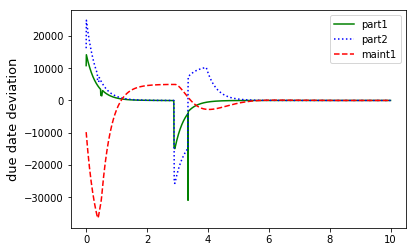

In [12]:
x = np.linspace(0,10,iterations+1)
char = ['g','b:','r--', 'c--']
l = ['part1','part2','maint1']
for i in range(num_parts+num_components): 
    plt.plot(x, save_due_date[:,i]-save_cmp[:,i], char[i])
plt.legend(l)
plt.ylabel('due date deviation', fontsize = 13)

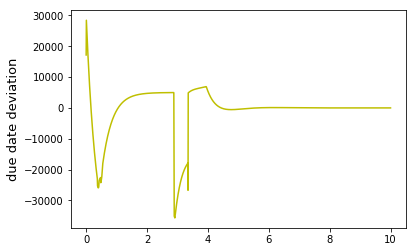

In [11]:
x = np.linspace(0,10,iterations+1)
char = ['y']
total_z = np.sum(save_due_date - save_cmp, 1)
plt.plot(x, total_z, char[0])
plt.ylabel('due date deviation', fontsize = 13)

In [ ]:
x = np.linspace(0,10,iterations+1)
char = ['g','b:','r--', 'c--']
l = ['part1','part2','maint1']
for i in range(num_parts+num_components): 
    plot(x, save_due_date[:,i]-save_cmp[:,i], char[i])
plt.legend(l)
plt.xlabel('due date deviation', fontsize = 13)

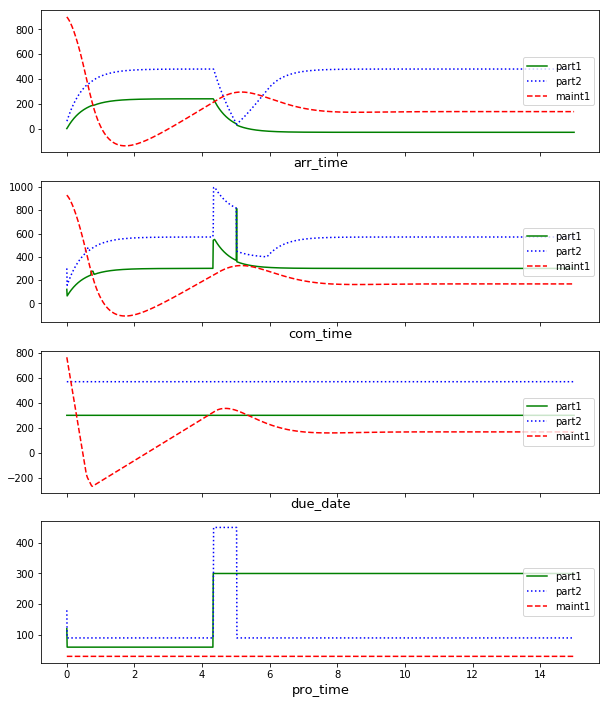

In [15]:
fig, ax = plt.subplots(4, figsize=(10, 12),sharex=True)
x = np.linspace(0,15,iterations+1)
char = ['g','b:','r--', 'c--']
l = ['part1','part2','maint1']
for i in range(num_parts+num_components): ax[0].plot(x, save_arr[:,i]/60, char[i])
for i in range(num_parts+num_components): ax[1].plot(x, save_cmp[:,i]/60, char[i])
for i in range(num_parts+num_components): ax[2].plot(x, save_due_date[:,i]/60, char[i])
for i in range(num_parts+num_components): ax[3].plot(x, save_p[:,i]/60, char[i])
ax[0].legend(l, loc = 7)
ax[1].legend(l, loc = 7)
ax[2].legend(l, loc = 7)
ax[3].legend(l, loc = 7)
ax[0].set_xlabel('arr_time', fontsize = 13)
ax[1].set_xlabel('com_time', fontsize = 13)
ax[2].set_xlabel('due_date', fontsize = 13)
ax[3].set_xlabel('pro_time', fontsize = 13)

In [228]:
def job_sequence_plot(parts, machine):
    print('series:', [p.series for p in parts])
    print('arr:', [p.arr_time for p in parts])
    print('comp:', [p.comp_time for p in parts])
    print('p_hat:', [p.hat_p for p in parts])
    print('p_bar:', [p.bar_p for p in parts])
    print('maint:', machine.maint_arr_time)
    print('dddev:', [p.z for p in parts])
    print('delta_machine:', machine.delta)
    fig, ax = plt.subplots(figsize=(10, 2))
    job_barh = []
    maint_barh = []
    for i in range(num_parts):
        job_barh.append((parts[i].comp_time, -parts[i].bar_p))
    ax.broken_barh(job_barh , (0, 3), facecolors='green')
    for j in range(machine.num_maint):
        maint_barh.append((machine.maint_due_date[j], -machine.tm))
    ax.broken_barh(maint_barh, (0, 3), facecolors='red')
    ax.set_ylim(0,6)
    ax.set_xlim(0,50)
    ax.set_xlabel('time')
    ax.set_yticks([1.5])
    ax.set_ylabel('jobs')
    ax.grid(True)

    plt.show()

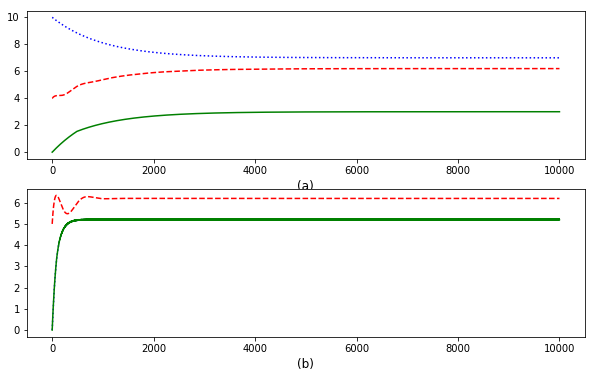

In [21]:
#the decoupling part 2
fig, ax = plt.subplots(2, figsize=(10, 6),sharex=False)
d = 10
k = 0.001
itera = 10000
a2 =np.zeros(itera+1)
p = save_p[:,1]
alpha = 0.001
a2[0] = 10
for i in range(itera):
    a2[i+1] = (d - p[i])*(1-np.exp(-k*i)) + a2[0]*np.exp(-k*i)
ax[0].plot(range(itera+1), a2, 'b:')
ax[0].plot(range(itera+1), a3, 'r--')
ax[0].plot(range(itera+1), a1, 'g-')
ax[1].plot(range(itera+1), save_arr[:,1], 'b:')
ax[1].plot(range(itera+1), save_arr[:,2], 'r--')
ax[1].plot(range(itera+1), save_arr[:,0], 'g-')
ax[0].set_xlabel('(a)', fontsize = 12)
ax[1].set_xlabel('(b)', fontsize = 12)

6.19990002022


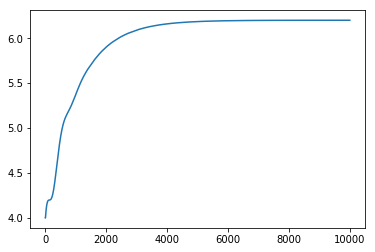

In [17]:
# the primary maintenance
d = save_due_date[:,2]
k = 0.001
itera = 10000
a3 =np.zeros(itera+1)
tm = 1
a3[0] = 4
for i in range(itera):
    a3[i+1] = (d[i] - tm)*(1-np.exp(-k*i)) + a3[0]*np.exp(-k*i)
plt.plot(range(itera+1), a3)
print(a3[-1])

In [13]:
#part 1 : the process time will be prolong by when t=489
d = 6
k = 0.001
itera = 10000
a1 =np.zeros(itera+1)
p = save_p[:,0]
alpha = 0.001
tm=1
a1[0] = 0
for i in range(itera):
    if i <= 489:
        a1[i+1] = (d - p[i])*(1-np.exp(-k*i)) + a1[0]*np.exp(-k*i)
    else:
        a1[i+1] = (d - p[i] - tm)*(1-np.exp(-k*(i-489))) + a1[489]*np.exp(-k*(i-489))

In [14]:
d = 10
RUL =3.5
tm = 1
r = np.array([[2,5,9],[5,3,9],[9,3,7],[9,7,4],[6,9,4],[2,9,6]])
turb = tm*(r >= RUL)
R = r+turb
zss = d-R
H = np.dot(np.dot(np.linalg.inv(np.dot(zss.transpose(), zss)), zss.transpose()),np.ones((6,1)))
ass = 1/np.sum(H)
ass

3.0476444100130733

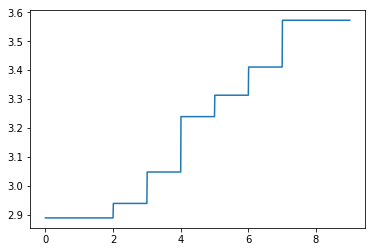

In [22]:
d = 10
RUL = 0
tm = 1
r = np.array([[2,5,9],[5,3,9],[9,3,7],[9,7,4],[6,9,4],[2,9,6]])
save_ass = []
RUL = np.linspace(0, 9, 1000)
for rul in RUL:
    turb = tm*(r>=rul)
    R = r+turb
    zss = d-R
    H = np.dot(np.dot(np.linalg.inv(np.dot(zss.transpose(), zss)), zss.transpose()),np.ones((6,1)))
    ass = 1/np.sum(H)
    save_ass = np.append(save_ass, ass)
plt.plot(RUL, save_ass)

In [33]:
##exp data per .25
x = np.linspace(0,5,21)
arr_data = np.array([[5.2, 5.2],
                     [5.20602391,  5.20602391],
                     [5.20602391,  5.20602391],
                     [5.20602391,  5.20602391],
                     [5.20602391,  5.20602391],
                     [5.20602391,  5.20602391],
                     [5.20602391,  5.20602391],
                     [5.20003254,  5.21003254],
                     [5.312291,    5.322291],
                     [5.35998841,  5.32998841],
                     [5.33332185,  5.34332185],
                     [5.35335582,  5.33335582],
                     [5.40560799,  5.38560799],
                     [5.7109287,   5.7309287],
                     [5.72848965,  5.71848965],
                     [5.72852358,  5.71852358],
                     [5.7342373,   5.7142373],
                     [5.72854462,  5.71854462],
                     [5.73425036,   5.71425036],
                     [5.74561073,   5.70561073],
                     [5.73425627,   5.71425627]])

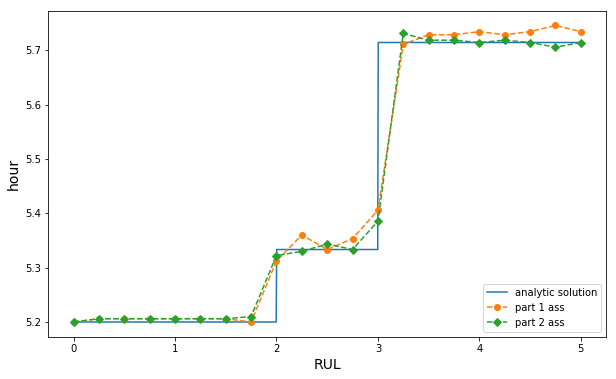

In [34]:
d = 10
RUL = 0
tm = 1
r = np.array([[2,5],[5,3]])
save_ass = []
RUL = np.linspace(0, 5, 1000)
for rul in RUL:
    turb = tm*(r>=rul)
    R = r+turb
    zss = d-R
    H = np.dot(np.dot(np.linalg.inv(np.dot(zss.transpose(), zss)), zss.transpose()),np.ones((2,1)))
    ass = 1/np.sum(H)
    save_ass = np.append(save_ass, ass)
fig, ax = plt.subplots(1, figsize=(10, 6),sharex=False)
ax.plot(RUL, save_ass, x, arr_data[:,0], '--o', x, arr_data[:,1], '--D')
ax.legend(['analytic solution', 'part 1 ass','part 2 ass'], loc=4)
ax.set_xlabel('RUL', fontsize = 14)
ax.set_ylabel('hour', fontsize = 14, rotation = 90)

In [26]:
d = 10
RUL = 1
tm = 1
turb = tm*(r>=RUL)
r = np.array([[2,5],[5,3]])
R = r+turb
zss = d-R
H = np.dot(np.dot(np.linalg.inv(np.dot(zss.transpose(), zss)), zss.transpose()),np.ones((2,1)))
ass = 1/np.sum(H)

In [27]:
H, ass

(array([[ 0.07692308],
        [ 0.11538462]]), 5.1999999999999993)

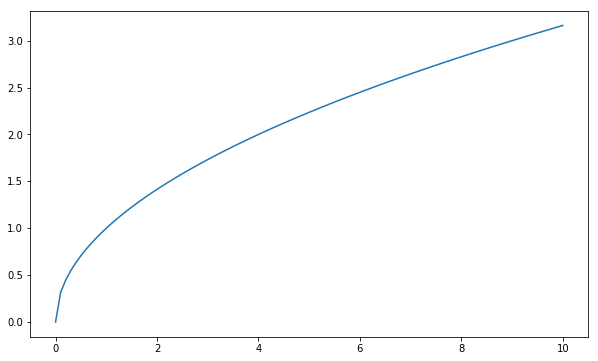

In [28]:
fig, ax = plt.subplots(1, figsize=(10, 6),sharex=False)
x = np.linspace(0, 10, 101)
y = np.sqrt(x)
ax.plot(x,y)

In [29]:
a = [1,2]
b = [2]
np.hstack((a,b))

array([1, 2, 2])